# Sistemas de Recomendación "tradicionales"

En esta serie de notebooks vamos a explorar algunas técnicas tradicionales de recomendación como:

*   Recomendación no personalizada y estereotipada.
*   Recomendación basada en contenido.
*   Recomendación basada en filtrado colaborativo.
*   Recomendación basada en factorización de matrices.

### Objetivos

Implementar algunos sistemas de recomendación simples para entender su funcionamiento utilizando un dataset de películas.

## Repasemos... qué son los sistemas de recomedación?

Los sistemas de recomendación se encuentran en la actualidad entre las aplicaciones de Data Science más populares. Son algoritmos "simples" que intentan proveer información relevante a los usuarios a partir de descubrir patrones en los datos. Por ejemplo, la frase típica que aparece en las tiendas virtuales "Quienes compraron esto, también compraron..."

<p align="center">
<img src="https://github.com/caiomiyashiro/RecommenderSystemsNotebooks/raw/359c2f549cec31842e14bee5a3dfdd252817f32f/images/notebook1_image1.jpeg" alt="Naïve recommendation" style="width: 400px;"/>
</p>

Aunque, también puede fallar:

<p align="center">
<img src="https://pbs.twimg.com/media/EkODBQ3XcAE2R_p?format=png&name=900x900
" alt="Naïve recommendation" width="400" height="400"/>
</p>


El uso masivo de Internet fue uno de los factores que potenció la importancia de los sistemas de recomendación. Debido a la sobrecarga de información que se "sufre" a diario, puede ser dificil encontrar (o incluso definir) aquello que se quiere o desea. En contrapartida, la gran cantidad de datos e información disponible permitió la creación de plataformas para su análsis y proveer a los usuarios solo la información que pueda resultarles relevante.

## Manos a la obra!

Para el propósito de este notebook, vamos a trabajar con colecciones de películas y sus ratings. Vamos a utilizar un [dataset](http://files.grouplens.org/datasets/movielens/ml-100k.zip) creado por la *University of Minnesota* que contiene 100k ratings pertenecientes a 1k usuarios sobre 1.7k películas.

## Recomendaciones no personalizadas

La forma más básica de recomendación es la **no personalizada**, que, como su nombre lo indica, no considera ni las preferencias de los individuos ni su contexto para la realización de las recomendaciones. 

Por ejemplo, pensemos en un usuario nuevo de Amazon (o su plataforma favorita de ventas por internet). Cuando recién cree su perfil no va a haber comprado ningún artículo, por lo que Amazon no va a poder conocer cuales son los intereses o gustos de este nuevo usuario. Entonces, la mejor manera para realizar las primeras recomendaciones a este usuario es mostrarle lo que otros usuarios hayan comprado, independientemente de sus gustos individuales. 







Lo primero que vamos a hacer es importar las bibliotecas necesarias:

In [9]:
import pandas as pd 
import numpy as np

A continuación, leeremos los datos utilizando `read_csv`. Las columnas del dataset se encuentra separadas por `\t`, de modo que debemos pasarlo como parámetro. Finalmente, también pasamos por parámetro los nombres de las columnas.


In [10]:
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-100k/u.data'
df = pd.read_csv(url, sep='\t', names=['user_id','movie_id','rating','timestamp'])

Vamos a imprimir parte de los datos para ver con qué estamos tratando.

In [11]:
df

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


Cada una de las filas representa el rating que un usuario le dió a una película. Entonces:

*   `user_id`. Id del usuario asignando el rating a la película.
*   `movie_id`. Id de la película a la que el `user_id` asignó el rating. 
*   `rating`. En escala de 1 a 5.
*   `timestamp`. Momento temporal en el que el rating fue asignado.

 Vamos a asociarle a cada id su título correspondiente. Para ello, cargamos el archivo que contiene el mapping entre los `ids` y los `movie_title` (y los géneros a los que pertenecen las películas).

In [12]:
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-100k/u.item'
movie_info = pd.read_csv(url,sep='|', encoding='latin-1', header=None, names=['movie_id','movie_title','release_date','movie_release_date',
                                                                              'IMDb url','unknown','Action','Adventure','Animation','Children','Comedy',
                                                                              'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical',
                                                                              'Mystery','Romance','Sci-Fi','Thriller','War','Western'])

movie_info = movie_info.drop('movie_release_date', axis=1) # eliminamos la columna movie_release_date que es NaN para todos los registros
movie_info = movie_info.drop('IMDb url', axis=1) # eliminamos esta columna que no aporta ninguna información relevante
movie_info.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Luego,  mergeamos ambos `data frames`.

In [13]:
df = pd.merge(df, movie_info, on='movie_id')
df.head()

,user_id,movie_id,rating,timestamp,movie_title,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Vamos a visualizar algunas estadísticas del dataset.

In [14]:
df.describe()

,user_id,movie_id,rating,timestamp,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,100000.00000,100000.000000,100000.000000,1.000000e+05,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,8.835289e+08,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,0.398950,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,330.798356,1.125674,5.343856e+06,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,0.489685,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,1.000000,1.000000,8.747247e+08,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,175.000000,3.000000,8.794487e+08,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,322.000000,4.000000,8.828269e+08,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,631.000000,4.000000,8.882600e+08,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,1682.000000,5.000000,8.932866e+08,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


Y ahora el histograma de los ratings.

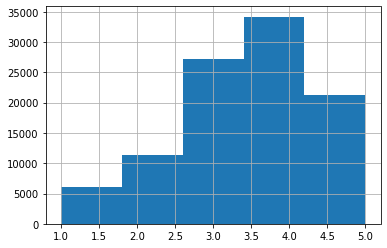

In [15]:
df['rating'].hist(bins=5)

La recomendación no personalizada generalmente se encuentra basada en el **cálculo de alguna métrica** que retorna un valor para cada elemento que luego permite ordenarlos. Por ejemplo:

*   ***Rating promedio***. Cuál es el rating promedio de un elemento particular?
*   ***Cantidad de ratings***. Una medida de popularidad. Cuántos usuarios ratearon un elemento? (ya sea para bien o para mal).
*    ***Porcentaje de buenos ratings***. Dado un *threshold* (por ejemplo, 4), qué porcentaje de usuarios dieron un buen rating al elemento?
*    ***Asociación***. Dados todos los usuarios que ratearon el elemento A, qué porcentaje de ellos también ratearon el elemento B?
*    ***Pearson Correlation***. Dado el rating que un usuario le dió al elemento A, se correlaciona con el rating que le dió al elemento B?

Vamos a crear dos funciones. Primero, una función que reciba todos los valores de la métrica `column` calculado y retorne el los mejores `n` elementos. Segundo, una función que nos permita graficar los resultados.


In [16]:
def return_best_n(statistics, n,column):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame(statistics)
    #statistics.head()
    return statistics.sort_values(by=column,axis=0, ascending = False).iloc[:n]

import matplotlib.pyplot as plt # la vamos a usar para graficar
import seaborn as sns

def graphics(statistics):
    plt.figure(figsize=(16,6))
    ax = sns.barplot(x=statistics['rating'], y=statistics['movie_title'], data=statistics, palette='deep')
    plt.title('Movie Ranking', weight='bold')
    plt.xlabel('Score', weight='bold')
    plt.ylabel('Movie Title', weight='bold')

Ahora, vamos a ver los resultados para distintas métricas.

#### Cantidad de ratings

In [17]:
ratings = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].count().reset_index())
ratings

,movie_title,rating
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41
...,...,...
1659,Young Guns II (1990),44
1660,"Young Poisoner's Handbook, The (1995)",41
1661,Zeus and Roxanne (1997),6
1662,unknown,9


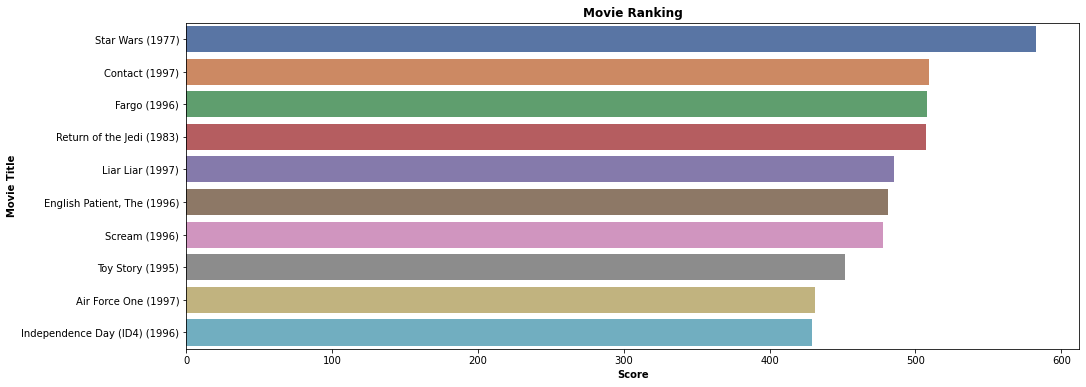

In [18]:
best = return_best_n(ratings,10,'rating')

graphics(best)

#### Rating promedio

Independientemente de la cantidad de ratings que hayan recibido las películas, cual es el promedio de esos rankings?


In [19]:
ratings = pd.DataFrame(df.groupby('movie_title',as_index = True)['rating'].mean()).reset_index()
best = return_best_n(ratings,10,'rating')
best.head()

,movie_title,rating
1472,They Made Me a Criminal (1939),5.0
944,Marlene Dietrich: Shadow and Light (1996),5.0
1273,"Saint of Fort Washington, The (1993)",5.0
1359,Someone Else's America (1995),5.0
1387,Star Kid (1997),5.0


En los resultados vemos que hay películas que tienen ratings promedio perfectos. Vamos a ver, para la película mejor rankeada cuántos ratings tuvo.

In [20]:
df[df['movie_title']=='They Made Me a Criminal (1939)'] # TODO: Completar con el título de la película mejor rankeada.

,user_id,movie_id,rating,timestamp,movie_title,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
99960,60,1122,5,883326498,They Made Me a Criminal (1939),01-Jan-1939,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


Aquellas películas que cuentan con un único rating no resultan muy útiles para la recomendación. 
Vamos a eliminar todas las películas que tengan menos ratings que el $25\%$ de las películas, es decir, el primer cuartil.

In [21]:
counts = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].count().reset_index())

print(counts.head())

first_quantile = counts['rating'].quantile(0.25)

print(first_quantile)

titles = counts[counts['rating'] > first_quantile]['movie_title'] #acá nos quedamos con los títulos de las pelis con una cantidad de reviews mayores al 1er quartil

df = df[df['movie_title'].isin(titles)]

df.shape


                 movie_title  rating
0  'Til There Was You (1997)       9
1               1-900 (1994)       5
2      101 Dalmatians (1996)     109
3        12 Angry Men (1957)     125
4                 187 (1997)      41
7.0


(98501, 25)

Ahora, volvemos a calcular el rating promedio:

In [22]:
ratings = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].mean().reset_index())
best = return_best_n(ratings,10,'rating')
best

,movie_title,rating
818,Pather Panchali (1955),4.625000
238,"Close Shave, A (1995)",4.491071
933,Schindler's List (1993),4.466443
1200,"Wrong Trousers, The (1993)",4.466102
202,Casablanca (1942),4.456790
1158,Wallace & Gromit: The Best of Aardman Animatio...,4.447761
959,"Shawshank Redemption, The (1994)",4.445230
884,Rear Window (1954),4.387560
1142,"Usual Suspects, The (1995)",4.385768
1022,Star Wars (1977),4.358491


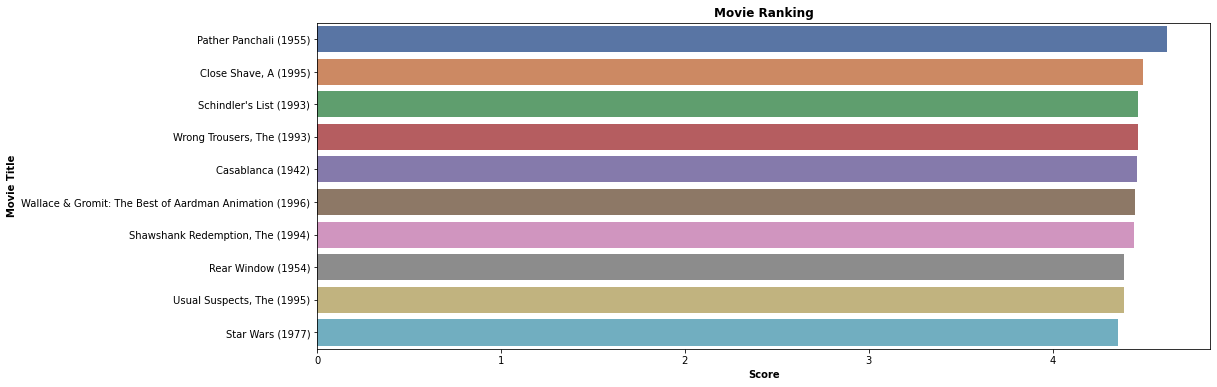

In [23]:
graphics(best)

#### Porcentaje de buenas reviews (>= 4)

Qué tenemos que hacer?

1.   Filtrar reviews con puntaje mayor o igual que 4.
2.   Dividir por el total de las reviews.

Tip: Resumen de las [funciones de agregación](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#descriptive-statistics)

In [24]:
counts = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].count().reset_index()) # como antes, contamos cuantos ratings tienen las películas

print(counts.head())

filtered = df[df['rating'] >= 4]  # filtramos las reviews con puntaje mayor o igual a 4
filtered = pd.DataFrame(filtered.groupby('movie_title',as_index=True)['rating'].count().reset_index()) # contamos cuantos ratings >= 4 tienen las películas

print(filtered.head())

merged = pd.merge(filtered, counts, on='movie_title') # mergeamos ambos data frames

merged.head()


                   movie_title  rating
0    'Til There Was You (1997)       9
1        101 Dalmatians (1996)     109
2          12 Angry Men (1957)     125
3                   187 (1997)      41
4  2 Days in the Valley (1996)      93
                   movie_title  rating
0    'Til There Was You (1997)       1
1        101 Dalmatians (1996)      31
2          12 Angry Men (1957)     109
3                   187 (1997)      15
4  2 Days in the Valley (1996)      38


,movie_title,rating_x,rating_y
0,'Til There Was You (1997),1,9
1,101 Dalmatians (1996),31,109
2,12 Angry Men (1957),109,125
3,187 (1997),15,41
4,2 Days in the Valley (1996),38,93


In [25]:
merged['rating'] = merged['rating_x'] / merged['rating_y']
best = return_best_n(merged,10,'rating')
best

,movie_title,rating_x,rating_y,rating
805,Pather Panchali (1955),8,8,1.000000
1139,Wallace & Gromit: The Best of Aardman Animatio...,61,67,0.910448
1127,Vertigo (1958),162,179,0.905028
1056,"Third Man, The (1949)",65,72,0.902778
944,"Shawshank Redemption, The (1994)",255,283,0.901060
412,Fresh (1994),9,10,0.900000
235,"Close Shave, A (1995)",100,112,0.892857
1181,"Wrong Trousers, The (1993)",105,118,0.889831
918,Schindler's List (1993),265,298,0.889262
200,Casablanca (1942),216,243,0.888889


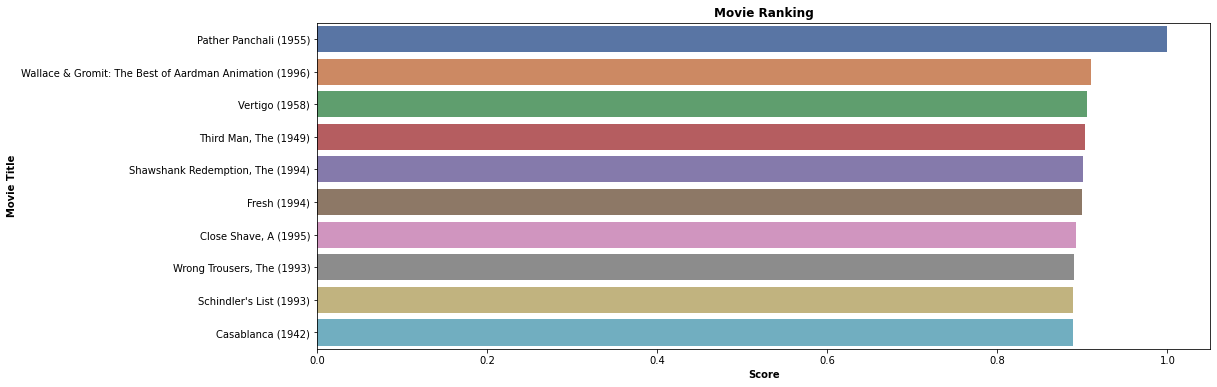

In [26]:
graphics(best)

#### Usando la métrica de IMDb

IMDb tuvo (todavía tiene?) su propia métrica para el agregado de los ratings de las películas, que se define como":

<p align="center">
<img src="https://miro.medium.com/max/552/1*fGziZl2Do-VyQXSCPq_Y2Q.png" alt="Weighted Rating" style="width: 400px;"/>
</p>

Qué tenemos que hacer?

1.   Calcular los ratings promedios de las películas (ya lo hicimos antes).
2.   Calcular la cantidad de ratings de las películas (ya lo hicimos antes).
3.   Calcular la cantidad mínima de ratings para estar en el Top de películas. En este caso como la cantidad de votos recibida por el 70% de las películas. (ya hicimos algo parecido).
4.    Calcular el rating promedio general (ya hicimos algo parecido).
5.    Calcular W a partir de todos los otros valores (ya hicimos algo parecido).



In [27]:
averages = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].mean().reset_index()) #calculamos el promedio de ratings de cada pelicula
counts = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].count().reset_index()) #calculamos la cantidad de ratings de cada pelicula 
minimum = counts['rating'].quantile(0.7) #calculamos la minima cantidad de ratings necesarios (cantidad de votos recibidos por el 70% de las peliculas)
general_average = df['rating'].mean() #calculamos el promedio de ratings de TODAS las peliculas

merged = pd.merge(averages, counts, on='movie_title') #mergeamos las peliculas que aparecen en averages y counts por el movie_title
print(merged.head()) #el merge define a rating_x al valor de rating para average y rating_y al valor de rating para counts
merged['IMDb Metric'] = (merged['rating_x']*merged['rating_y'] + general_average*minimum)/(merged['rating_y'] + minimum) #la metrica se calcula como (R*v + C*m)/(v+m)

best = return_best_n(merged,10,'IMDb Metric') #calculamos las 10 mejores peliculas en base a la metrica de IMBd
best

                   movie_title  rating_x  rating_y
0    'Til There Was You (1997)  2.333333         9
1        101 Dalmatians (1996)  2.908257       109
2          12 Angry Men (1957)  4.344000       125
3                   187 (1997)  3.024390        41
4  2 Days in the Valley (1996)  3.225806        93


,movie_title,rating_x,rating_y,IMDb Metric
933,Schindler's List (1993),4.466443,298,4.248488
1022,Star Wars (1977),4.358491,583,4.247274
959,"Shawshank Redemption, The (1994)",4.445230,283,4.223761
202,Casablanca (1942),4.456790,243,4.205702
1142,"Usual Suspects, The (1995)",4.385768,267,4.169666
456,"Godfather, The (1972)",4.283293,413,4.148337
968,"Silence of the Lambs, The (1991)",4.289744,390,4.147117
884,Rear Window (1954),4.387560,209,4.129270
875,Raiders of the Lost Ark (1981),4.252381,420,4.124825
1091,Titanic (1997),4.245714,350,4.099344


#### Pearson Correlation

El análisis de correlaciones evalúa si el rating que un usuario da a un elemento A puede dar "pistas" respecto al rating que daría al elemento B. 

Una correlación cercana a $1$ indica que los usuarios tienen a darle a ambas películas involucradas ratings similares. En este caso, se permiten realizar recomendaciones del tipo "Como te gustó X, te podría gustar Y".

Vamos a calcular la correlación del rating medio de las películas respecto a la película con el promedio de ratings en la mediana (es decir, la película cuyo rating promedio se encuentra en el cuartil $0.5$).


In [28]:
averages = pd.DataFrame(df.groupby('movie_title',as_index=True)['rating'].mean().reset_index()) #calculamos el promedio de rating de cada pelicula
mediana = averages.quantile(0.5) #calculamos el valor del rating que se encuentra en el cuartil 0.5

print(averages.head())
print('mediana',mediana[0])

median_movie = averages[averages['rating'] == mediana[0]] #nos quedamos con la pelicula que tenga rating igual a la mediana 
median_movie = median_movie['movie_title'] # en caso de que haya más de una, nos quedamos con la primera que retornó -> iloc[0]
median_movie

                   movie_title    rating
0    'Til There Was You (1997)  2.333333
1        101 Dalmatians (1996)  2.908257
2          12 Angry Men (1957)  4.344000
3                   187 (1997)  3.024390
4  2 Days in the Valley (1996)  3.225806
mediana 3.3125


588    Jumanji (1995)
925       Rudy (1993)
Name: movie_title, dtype: object

In [29]:
# documentación del pivot_table: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

# recordemos que dataframe df tiene las películas con cantidad de reviews mayor que la cantidad de reviews del 25% de ellas

# para calcular la correlación necesitamos una matriz de películas x ratings (size users x peliculas) donde las columnas representen a cada una de las películas, las filas a cada usuario y el valor es el rating asignado
movie_matrix = df.pivot_table(index='user_id', columns='movie_title', values='rating') 

movie_matrix.head()

movie_title,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Alice in Wonderland (1951),Alien (1979),Alien 3 (1992),Alien: Resurrection (1997),Aliens (1986),All About Eve (1950),All Dogs Go to Heaven 2 (1996),Alphaville (1965),...,Welcome to the Dollhouse (1995),Wes Craven's New Nightmare (1994),What Happened Was... (1994),What's Eating Gilbert Grape (1993),What's Love Got to Do with It (1993),When Harry Met Sally... (1989),When We Were Kings (1996),When a Man Loves a Woman (1994),When the Cats Away (Chacun cherche son chat) (1996),While You Were Sleeping (1995),"White Balloon, The (1995)",White Man's Burden (1995),White Squall (1996),Widows' Peak (1994),Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),"Wizard of Oz, The (1939)",Wolf (1994),"Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wrong Trousers, The (1993)",Wyatt Earp (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",unknown
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,1.0,NaN,...,5.0,NaN,NaN,4.0,NaN,5.0,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,3.0,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,4.0,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,4.0


In [30]:
# nos quedamos con la columna de los ratings de la película que queremos. El size es de users x 1
median_movie_ratings = movie_matrix[median_movie]
print(median_movie_ratings)
print('Shape:',median_movie_ratings.shape)

# calculamos la correlación de toda la matriz con la columna seleccionada. El resultado es una matriz de películas x películas (Es de peliculas x 1)
correlation = movie_matrix.corrwith(median_movie_ratings)
print('Shape correlacion', correlation.shape)

correlation.sort_values(ascending=False) #ordenamos

corr_contact = pd.DataFrame(correlation, columns=['Correlation']) #pasamos a un data frame
corr_contact.dropna(inplace=True) # sacamos los NaN
corr_contact.head()


movie_title  Jumanji (1995)  Rudy (1993)
user_id                                 
1                       NaN          NaN
2                       NaN          NaN
3                       NaN          NaN
4                       NaN          NaN
5                       NaN          NaN
...                     ...          ...
939                     NaN          NaN
940                     NaN          NaN
941                     NaN          NaN
942                     NaN          NaN
943                     NaN          2.0

[943 rows x 2 columns]
Shape: (943, 2)
Shape correlacion (1207,)


,Correlation
movie_title,
Jumanji (1995),1.0
Rudy (1993),1.0


## Recomendación estereotipada

Una pequeña "mejora" que se puede hacer a la recomendación no personalizada es la recomendación estereotipada. Por ejemplo, los rankings por sexo/género, edad o ciudad, pueden mejorar la calidad de las recomendaciones si se cree que entre los elementos a recomendar existe realmente una diferenciación de acuerdo a las características de los diferentes segmentos.

Qué pasa si tenemos en cuenta información demográfica para hacer las recomendaciones? Por ejemplo, varían las recomendaciones si consideramos el sexo/género de quienes ratearon las películas?

Primero, tenemos que cargar la información de los usuarios y mergearla en la tabla de reviews.

In [31]:
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-100k/u.user'
user_info = pd.read_csv(url, sep='|', names=['user_id','age','gender','occupation','zip_code'])

user_info.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [32]:
df = df.merge(user_info, on='user_id',how='inner')
df.head()

,user_id,movie_id,rating,timestamp,movie_title,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105


In [33]:
# Películas mejor rankeadas para mujeres
averages_F = pd.DataFrame(df[df['gender'] == 'F'].groupby('movie_title',as_index=True)['rating'].mean().reset_index())
best = return_best_n(averages_F,10,'rating')
best

,movie_title,rating
1055,Telling Lies in America (1997),5.000000
405,Foreign Correspondent (1940),5.000000
929,Schindler's List (1993),4.632911
238,"Close Shave, A (1995)",4.631579
955,"Shawshank Redemption, The (1994)",4.562500
1152,Wallace & Gromit: The Best of Aardman Animatio...,4.533333
952,Shall We Dance? (1996),4.529412
420,Friday (1995),4.500000
1191,"Women, The (1939)",4.500000
90,"Band Wagon, The (1953)",4.500000


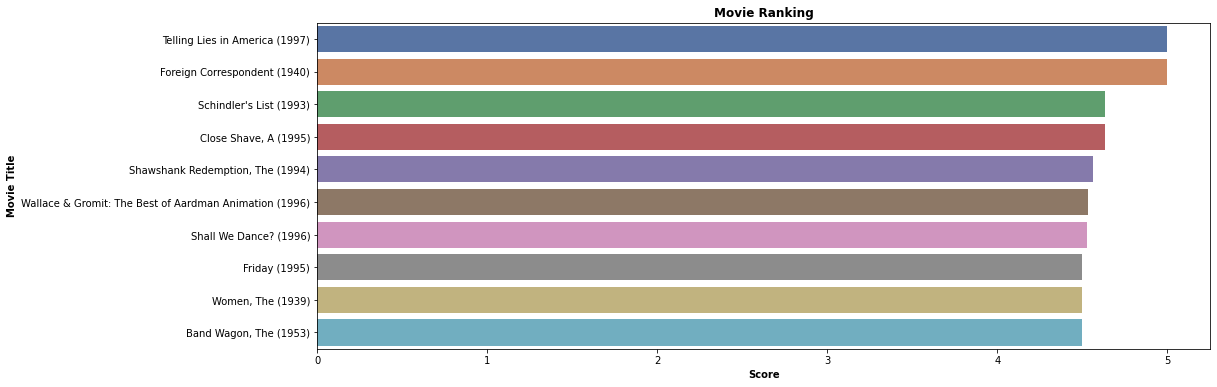

In [34]:
graphics(best)

In [35]:
# Películas mejor rankeadas para hombres
averages_M = pd.DataFrame(df[df['gender'] == 'M'].groupby('movie_title',as_index=True)['rating'].mean().reset_index())
best = return_best_n(averages_M,10,'rating')
best

,movie_title,rating
640,"Little Princess, The (1939)",4.666667
818,Pather Panchali (1955),4.625000
9,A Chef in Love (1996),4.500000
202,Casablanca (1942),4.473404
1200,"Wrong Trousers, The (1993)",4.472527
238,"Close Shave, A (1995)",4.462366
1074,"Third Man, The (1949)",4.433333
1158,Wallace & Gromit: The Best of Aardman Animatio...,4.423077
819,Paths of Glory (1957),4.419355
959,"Shawshank Redemption, The (1994)",4.410959


#### Diferencia de rating promedio

En qué películas los hombres y mujeres tienen mayores diferencias para calificar?


In [36]:
merged = pd.merge(averages_F, averages_M, on='movie_title', suffixes=['_F',"_M"])

merged['f-m'] = merged['rating_F'] - merged['rating_M']

highest = return_best_n(merged,10,'f-m')
highest

,movie_title,rating_F,rating_M,f-m
214,Chairman of the Board (1998),4.000000,1.714286,2.285714
1055,Telling Lies in America (1997),5.000000,3.083333,1.916667
1038,Sunset Park (1996),4.000000,2.285714,1.714286
1116,Turbulence (1997),4.000000,2.428571,1.571429
31,Alaska (1996),3.750000,2.222222,1.527778
399,"Fog, The (1980)",4.000000,2.550000,1.450000
826,Phantoms (1998),3.333333,1.900000,1.433333
278,Dangerous Ground (1997),3.000000,1.571429,1.428571
958,Shiloh (1997),4.000000,2.600000,1.400000
1186,Wishmaster (1997),3.428571,2.100000,1.328571


In [37]:
# y al revés? 
merged['m-f'] = merged['rating_M'] - merged['rating_F']

highest = return_best_n(merged,10,'m-f')
highest

,movie_title,rating_F,rating_M,f-m,m-f
815,Paths of Glory (1957),1.00,4.419355,-3.419355,3.419355
1005,Stalker (1979),1.00,3.800000,-2.800000,2.800000
1004,Stalingrad (1993),1.00,3.600000,-2.600000,2.600000
1193,Wonderland (1997),1.00,3.444444,-2.444444,2.444444
124,"Big Blue, The (Grand bleu, Le) (1988)",1.00,3.375000,-2.375000,2.375000
553,Incognito (1997),2.25,4.333333,-2.083333,2.083333
212,Cemetery Man (Dellamorte Dellamore) (1994),1.00,2.954545,-1.954545,1.954545
341,"Endless Summer 2, The (1994)",1.00,2.875000,-1.875000,1.875000
134,Bitter Moon (1992),2.00,3.857143,-1.857143,1.857143
1176,Wild Bill (1995),1.00,2.800000,-1.800000,1.800000


## Ventajas y desventajas de la recomendación no personalizada

### Ventajas

*   No se necesita tener información previa de los usuarios respecto a sus gustos.
*   Las estadísticas calculadas con simple y fácilmente explicables.

### Desventajas

*    Para poder proveer buenas estadísticas, los elementos deben tener una cantidad razonable de reviews/ratings, lo que también implica tener una cantidad razonable de usuarios.
*    Al tratar a todos los usuarios de la misma forma, no es posible la identificación de grupos de usuarios (no referido solo a grupos demográficos).
*    Las recomendaciones estereotipadas solo serán útiles si existen productos que fueron específicamente diseñados para dichos grupos.


## Peeero, un problema salvaje aparece!

Como vimos, estas recomendaciones simples se encuentran basadas en *scores* que pueden ser calculadas a partir de indicadores básicos:

*    *Explícitos*. Evaluaciones provistas de forma directa por los usuarios, por ejemplo, ratings, scores, likes, ...
*    *Implícitos*. Derivadas del comportamiento implícito del usuario como por ejemplo clicks, tiempo en una página, accesos, ...

The most basic way to provide recommendations is a non-personalised one que no tome en ceunta las preferencias individuales de los usuarios. 

Las métricas ***explícitas*** son "buenas" porque se puede preguntar de forma directa al usuario qué es lo que piensa. Sin embargo, algunos problemas aparecen.

1.   Cómo los usuarios saben como reflejar sus gustos en un valor numérico?
2.   La definición de los ratings varía de usuario a usuario. Por ejemplo, algunos usuarios pueden ratear la película con un 5 cuando es lo que esperaba, mientras que para otros eso representa un rating de 3 y solo califican con 5 a aquellas películas que superaron sus expectativas.
3.   La definición de los ratings varía a lo largo del tiempo. Un usuario puede dar dos ratings distintos para el mismo elemento en distintos momentos temporales.

Por otra parte, las ***implícitas*** asumen que las acciones de los usuarios "dicen más que su palabras". Recolectar comportamiento es más rápido que esperar a que el usuario asigne ratings, y se encuentra ajeno al juicio humano inherente a las métricas explícitas. Sin embargo, tratar con las múltiples variables derivadas del comportamiento puede no ser sencillo, debiendo definir adecuadamente los pesos a considerar de acuerdo al dominio.

### Rating con estrellas

Uno de los tipos principales de ratings que se utiliza hoy en día se encuentra basado en 5 estrellas. Utilizado por empresas como Amazon, y anteriormente por Netflix y TripAdvisor, el objetivo es trazar un perfil entre los usuarios y sus productos para realizar recomendaciones tanto no personalizadas como personalizadas.

Pero, *qué significa asignar 1 o 5 estrellas?*

Las dificultades comienzan cuando la escala no se encuentra configurada o definida correctamente. Por supuesto, existen límites para ello, pero generalmente no se  proporcionan referencias concretas en las que basar la calificación. Este escenario trae inestabilidad a las distribuciones de calificaciones y empeora debido a la percepción humana, que tiende a asignar ratings de forma instantánea.

*Evaluación contextual y temporal*

El gusto y los intereses de los usuarios puede variar mucho según el contexto. Es así que, utilizar funciones agregadas de los ratings puede involucrar cálculos sobre ratings provistos en distintos contextos, lo que puede dar lugar a recomendaciones inestables y no confiables.

[Fischhoff (1991)](https://www.cmu.edu/dietrich/sds/docs/fischhoff/ValueElictationAnythngThere.pdf) estudió qué es lo que los usuarios tienen en cuenta al momento de asignar los ratings, encontrando que los mismos son asignados de forma instantánea, sin consierar factores históricos como el gusto personal o las características del nuevo elemento en relación a los elementos previos. Simplemente, se trata de *me gustó* o *no me gustó*. El problema con esta situación es que los ratings que asignan los usuarios a los elementos pueden variar si vuelven a ser asignados, lo que les agrega más ruido.

### Efecto de la variabilidad de los ratings

Supóngase que se cuenta con un elemento que tiene un rating promedio de $4.8$. Ahora, un nuevo usuario le asigna un rating de $1$. En este contexto, considerando que nos quedamos solo con los últimos $100$ ratings asignados, el nuevo rating será: 

$$4.8 - \frac{4.8 - 1}{100} = 4.762$$  

Ahora, cuál será el rating si en lugar de aisgnar un $1$, se hubiese asignado un $5$?

$$4.8 - \frac{4.8 - 5}{100} = 4.802$$

Nótese que el efecto de un mal ranking es mayor que el efecto de un buen ránking. El problema es que el promedio asigna un mayor peso a los scores que se encuetran más lejanos al promedio. Entonces, como el promedio que teníamos estaba más cercano al $5$ que al $1$, el $1$ tiene un mayor impacto en el promedio final.

Pero, qué pasaría si se quisiera recuperar el rating promedio que se tenía antes del $1$? Es decir, cuántos ratings de $5$ son necesarios para volver al promedio anterior?


In [38]:
rating_promedio_actual = 4.762
count = 0
while(rating_promedio_actual <= 4.8):
    rating_promedio_actual = rating_promedio_actual - ((rating_promedio_actual - 5)/100)
    print('Nuevo Rating: ' + str(rating_promedio_actual))
    count += 1
print('Se necesitaron ' + str(count) + ' ratings para volver al promedio original.')

Nuevo Rating: 4.764379999999999
Nuevo Rating: 4.7667361999999995
Nuevo Rating: 4.769068838
Nuevo Rating: 4.77137814962
Nuevo Rating: 4.7736643681238
Nuevo Rating: 4.775927724442562
Nuevo Rating: 4.778168447198136
Nuevo Rating: 4.780386762726155
Nuevo Rating: 4.782582895098893
Nuevo Rating: 4.784757066147904
Nuevo Rating: 4.786909495486425
Nuevo Rating: 4.789040400531561
Nuevo Rating: 4.791149996526245
Nuevo Rating: 4.793238496560983
Nuevo Rating: 4.795306111595373
Nuevo Rating: 4.797353050479419
Nuevo Rating: 4.799379519974625
Nuevo Rating: 4.801385724774879
Se necesitaron 18 ratings para volver al promedio original.


Entonces, considerando un promedio original de $4.8$ se requirieron $18$ ratings de $5$ puntos para volver a dicho promedio original, sin contar la posibilidad de que otro usuario le haya asignado otro $1$.

#### Qué se puede hacer?

* Mantener los ratings, pero considerar también la variabilidad en los procesos de rateo de los usuarios.

Debería funcionar de la misma forma que las métricas que utilizamos hasta ahora, con la diferencia que el rating o score final dado a un elemento ahora considera cuánto se desvía el rating asignado respecto al rating promedio asignado por el usuario. Dado el promedio anterior $Sc_{D}$, el rating promedio del usuario $AVG(R_{p})$ y el rating del elemento actual $R_{p,d}$, el rating debería ser actualizado como:

$$Sc_{D} = Sc_{D} + \frac{AVG(R_{p}) - R_{p,d}}{100}$$

Este enfoque solo soluciona los problemas de escala entre los distintos usuarios, pero no soluciona la penalización que el promedio da a los ratings bajos que los usuarios dan a elementos con promedios altos.

* Utilizar valoraciones binarias (solo positivo o negativo).

Como el actualmente utilizado por Netflix. Permite hacer más sencillo el problema de asignar ratings.


## Recomendación basada en contenido

En este tipo de recomendaciones, no se necesita contar con una gran cantidad de usuarios, sino contar con una descripción de los elementos y los perfiles de los usuarios, los cuales deben matchear. 

### Ventajas

*   No se necesita gran cantidad de usuarios para proveer recomendaciones confiables.
*   Pueden darse recomendaciones solo considerando las características de los elementos.

### Desventajas

* Las descripciones de los elementos pueden no ser sencillas de construir.
* Los usuarios no realizan descripciones de forma homogénea.


Una forma muy sencilla de realizar recomendaciones basadas en contenido es hacer uso de los tags que les fueran asignados a los elementos.

Para esta primera parte, vamos a usar otro [dataset](https://raw.githubusercontent.com/codeheroku/Introduction-to-Machine-Learning/master/Building%20a%20Movie%20Recommendation%20Engine/movie_dataset.csv) que también tiene información de películas, género, director, tags, actores y demás; y una biblioteca para hacer más fácil los cálculos.

In [39]:
# como veníamos haciendo antes, vamos a cargar el dataset
url = 'https://raw.githubusercontent.com/codeheroku/Introduction-to-Machine-Learning/master/Building%20a%20Movie%20Recommendation%20Engine/movie_dataset.csv'
movies_2 = pd.read_csv(url)

movies_2


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,4798,220000,Action Crime Thriller,NaN,9367,united states\u2013mexico barrier legs arms pa...,es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,Carlos Gallardo Jaime de Hoyos Peter Marquardt...,"[{'name': 'Robert Rodriguez', 'gender': 0, 'de...",Robert Rodriguez
4799,4799,9000,Comedy Romance,NaN,72766,NaN,en,Newlyweds,A newlywed couple's honey

Al visualizar el dataset se observa que existe información extra acerca de las películas, la cual no es necesaria. Entonces, vamos solo a seleccionar los tags o `keywords`, el `cast`, el `overview`, los `genres` y el `director`, es decir, todo aquello que pueda conseridarse como `contenido` de las películas. 

Para ello, vamos a seleccionar esos features y crear una función que nos haga el `join` de todos esos campos

In [40]:
features = ['keywords','cast','genres','director','overview']

In [41]:
def combine_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']+" "+row['overview']

Ahora necesitamos invocar a la función `combine_feature` a cada fila del data frame. Pero antes de eso, vamos a "limpiar"  y pre-procesar los datos. Para ello vamos a reemplazar los `NaN` por espacios en blanco.


In [42]:
for feature in features:
    movies_2[feature] = movies_2[feature].fillna('') #filling all NaNs with blank string

movies_2['combined_features'] = movies_2.apply(combine_features,axis=1) #applying combined_features() method over each rows of dataframe and storing the combined string in "combined_features" column

movies_2[['original_title','combined_features']].head()

,original_title,combined_features
0,Avatar,culture clash future space war space colony so...
1,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...
2,Spectre,spy based on novel secret agent sequel mi6 Dan...
3,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...
4,John Carter,based on novel mars medallion space travel pri...


Una vez que se tienen los `String` combinados, se puede utilizar un `CountVectorizer()` para obtener la matriz de frecuencias.


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer() #creating new CountVectorizer() object
count_matrix = cv.fit_transform(movies_2['combined_features']) #feeding combined strings(movie contents) to CountVectorizer() object

print(cv.get_feature_names())
print(count_matrix.toarray())
print(count_matrix.shape) #Esta matriz es de movies x palabras

['00', '000', '007', '07am', '10', '100', '1000', '101', '108', '10th', '11', '114', '117', '118', '119', '11th', '12', '1200', '1215', '1250', '125th', '12th', '13', '1300', '13th', '14', '140', '1408', '142', '1429', '148', '14pm', '14th', '15', '150', '150th', '1520s', '1536', '15th', '16', '1600s', '161', '1630s', '1644', '1681', '1691', '16th', '17', '170', '1700s', '173rd', '1748', '1776', '17th', '18', '180', '1800', '1818', '1820', '1820s', '1824', '1831', '1834', '1836', '1838', '1839', '1841', '1845', '1850', '1850s', '1856', '1857', '1860', '1862', '1863', '1870s', '1875', '1876', '1879', '1880s', '1882', '1885', '1889', '1890', '1890s', '18th', '19', '1900', '1900s', '1903', '1905', '191', '1910', '1910s', '1911', '1912', '1914', '1915', '1917', '1918', '1919', '1920', '1920s', '1921', '1922', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1930s', '1931', '1932', '1933', '1934', '1936', '1937', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946

Vamos a calcular el `cosine similarity`:

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix) # nos retorna un numpy.ndarray

cosine_sim.shape #Esta matriz es de movies x movies

(4803, 4803)

El próximo paso es obtener los títulos de las películas en las que los usuarios se encuentran actualmente interesados. Luego, vamos a encontar el índice de la película y relacionarlo con la semejanza calculada. Finalmente, vamos a obtener la semejanza para con todas las otras películas de una película dada. Dichas semejazas son enumeradas y transformadas en una tupla que contiene `(movie id, similarity score)`.


In [45]:
movie_user_likes = "Harry Potter and the Order of the Phoenix"
movie_index = movies_2[movies_2['original_title'] == movie_user_likes]["index"].values[0]
print('Index of ',movie_user_likes,' is ',movie_index)
similar_movies = list(enumerate(cosine_sim[movie_index])) #accedemos a la fila correspondiente a una película dada para obtener sus semejanzas con el resto.
print(similar_movies[:10])
print('Similitud con ella misma debe ser 1',similar_movies[movie_index])

Index of  Harry Potter and the Order of the Phoenix  is  113
[(0, 0.1447493728911492), (1, 0.2727723627949905), (2, 0.25414752525052176), (3, 0.25846798715187674), (4, 0.29121008332370574), (5, 0.2209914235945042), (6, 0.2468853599393471), (7, 0.29939247542604785), (8, 0.5082054708931045), (9, 0.22009821317589895)]
Similitud con ella misma debe ser 1 (113, 0.9999999999999996)


Ahora viene la parte más importante. Como veníamos haciendo antes, hay que ordenar la lista de películas similares de forma descendente, descartando a si misma de la lista.


In [46]:
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

sorted_similar_movies = sorted_similar_movies[0:10] # nos interesan solo las 10 primeras

x = [p[0] for p in sorted_similar_movies] # obtenemos los index de las películas

movie_titles = movies_2[movies_2['index'].isin(x)]

movie_titles['original_title']

8             Harry Potter and the Half-Blood Prince
114              Harry Potter and the Goblet of Fire
197         Harry Potter and the Philosopher's Stone
230     Star Wars: Episode II - Attack of the Clones
448                                    Cold Mountain
599                                       Hart's War
610                           The Legend of Hercules
769                 Sinbad: Legend of the Seven Seas
3957                                     The Eclipse
4777                                          Manito
Name: original_title, dtype: object

### Volviendo al dataset que estábamos usando...

El dataset que tenemos cargado, no tiene asociado contenido para las diferentes películas ni tags ni reviews, así que vamos a cargar otro archivo con tags para cada película.

In [47]:
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-20m/tags.csv'
tags = pd.read_csv(url, sep=',', names=['user_id','movie_id','tag','timestamp'],header=0)

url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-20m/movies.csv'
full_movies = pd.read_csv(url, sep=',', names=['movie_id','movie_title','genres'],header=0)
full_movies = full_movies.drop('genres', axis=1) # tenemos que cargar los títulos porque los ids de las películas difieren de dataset en dataset

tags = pd.merge(tags,full_movies, on='movie_id')

print(str(tags.shape))

tags.head()

(465564, 5)


,user_id,movie_id,tag,timestamp,movie_title
0,18,4141,Mark Waters,1240597180,Head Over Heels (2001)
1,66193,4141,naive,1294446130,Head Over Heels (2001)
2,70201,4141,Mark Waters,1308333224,Head Over Heels (2001)
3,89274,4141,Freddie Prinze Jr.,1375164095,Head Over Heels (2001)
4,65,208,dark hero,1368150078,Waterworld (1995)


Como este dataset tiene muchas más películas que con el que veníamos trabajando, vamos a eliminar todos los tags pertenecientes a las películas que no tenemos.

In [49]:
df = pd.merge(df, movie_info, on='movie_id')
titles = df['movie_title'] #acá nos quedamos con los títulos de las pelis con una cantidad de reviews mayores al 1er cuartil (lo que habíamos calculado para los otros tipos de recomendaciones)

tags = tags[tags['movie_title'].isin(titles)]
print(str(tags.shape))

tags.head()

(75090, 5)


,user_id,movie_id,tag,timestamp,movie_title
4,65,208,dark hero,1368150078,Waterworld (1995)
5,619,208,Kevin Costner,1187162734,Waterworld (1995)
6,2062,208,adventure,1286238272,Waterworld (1995)
7,2062,208,dystopia,1286238251,Waterworld (1995)
8,2062,208,dystopic future,1286238259,Waterworld (1995)


Ahora ya tenemos la información de los tags para las diferentes películas que ya teníamos. En el dataframe `tags` cada fila representa una asignación de `tag` a una película.
Vamos a poder:

*   Crear descripciones de las películas en base a todos los tags que les hayan sido asignados. Con esto se puede determinar la semejanza entre las películas.
*   Crear perfiles de los usuarios con todos los tags que haya asignado a las películas. Con esto luego se puede determinar su semejanza con la descripción de otras películas u otros usuarios.



In [50]:
# creación de las descripciones de las películas

tag_matrix = tags.pivot_table(index='user_id', columns='movie_title', values='tag',aggfunc='first')
tag_matrix.head()

tag_matrix['101 Dalmatians (1996)'].dropna() # ejemplo para ver los tags asociados a una película determinada

user_id
1741                    adapted from:book
3761                           glen close
9197                               Disney
12288                       Stephen Herek
18390                        17th century
22320          Dr House with more make-up
42640                                seen
44981                                 fun
70201                       Stephen Herek
77463                            children
84288     animation remade as live action
88738                     based on a book
96370                                dogs
104790                             Disney
112783                         Dalmatians
114937                            cartoon
117270                             acting
121055                            animals
121403                       animal movie
123297                               70mm
134419                             Disney
Name: 101 Dalmatians (1996), dtype: object

In [ ]:
# creación de los perfiles de usuario
#user_tag_matrix = tags.pivot_table(index='movie_title', columns='user_id', values='tag',aggfunc='first')
#user_tag_matrix.head()
tags
#user_tag_matrix[65].dropna() # ejemplo para ver el perfil de un usuario en particular

Ahora, ya podemos calcular las semejanzas con los perfiles!

#### Tarea!

Considerando el dataframe original:


*   Armar los perfiles de los usuarios considerando los tags que haya asignado a películas que haya dado una mala calificación ($<2$). Vamos a suponer que esas películas no son del agrado de los usuarios.
  *  Para esto pueden probar de mergear los `data frames` y filtrar cómo ya hicimos antes.
*   Dado un usuario cualquiera, encontrar el ranking de las 10 películas más disimilares que no haya rateado.
  * Dado un usuario, pueden seleccionar su perfil.
  * Seleccionar las películas que no haya rateado.
  * Calcular la semejanza entre esas películas y su perfil.
  * Ordenar y obtener las 10 más disimilares.

Al seleccionar las disimiles, descartar todas aquellas con las que tenga una similarity de $0$.


In [ ]:
# TODO!

#Cargamos el dataset nuevamente
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-100k/u.data'
movies = pd.read_csv(url, sep='\t', names=['user_id', 'movie_id', 'rating','timestamp'])
movies
url = 'https://raw.githubusercontent.com/tommantonela/sistemasRecomendacion2019/master/ml-20m/tags.csv'
tags = pd.read_csv(url, sep=',', names=['movie_id','tag','timestamp'],header=0)
tags

filtered = movies[movies['rating'] < 2] 
filtered = pd.DataFrame(filtered.groupby(by=['user_id','movie_id'],as_index=True)['rating'].count().reset_index())
filtered

tags_movie = pd.merge(filtered, tags, on='movie_id')
tags_movie

# usar pivot para construir la matriz de usuarios x películas (perfiles de las películas)
tag_matrix = tags_movie.pivot_table(index='user_id', columns='movie_id', values='tag',aggfunc='first')
tag_matrix.head()
tag_matrix[4141].dropna()

#user_tag_matrix = tags_movie.pivot_table(index='tag', columns='user_id', values='tag',aggfunc='first')
#user_tag_matrix.head()


# usar pivot para construir la matriz de películas x usuarios (perfiles de los usuarios)

# calcular semejanzas, ordenar y seleccionar top-10

Otra posibilidad es construir los perfiles de usuario, seleccionar los $n$ usuarios más similares. Una vez que se los obtuvo, para un usuario particular, de las películas que los más similares hayan rateado, seleccionar aquellas con mayor rating promedio.

In [ ]:
# TODO!

# Opción 1:
    # construir los perfiles como se hizo en el caso anterior
    # vectorizar y calcular semejanza entre usuarios usando cosine similarity como se hizo en el caso anterior

# Opción 2:
    # usar pivot para construir la matrix de películas x usuarios con los tags para armar los perfiles de cada usuario con el cuidado de que un usuario pudo haber asignado más de un tag a una película
    # una vez construida la matriz, hacer append de todos los tags por cada usuario (es decir por cada columna) y obtener una lista de str donde cada posición se corresponde con un usuario
    # aplicar vectorizer y calcular la semejanza del coseno como hicimos en el ejemplo de semejanza de contenido

# Opción 3: 
    # hacer append de todos los tags para un usuario dado desde el dataframe de tags (quedándonos con una lista de str donde cada posición se corresponde con un usuario)
    # aplicar vectorizer y calcular la semejanza del coseno como hicimos en el ejemplo de semejanza de contenido
 
# A partir de acá, lo mismo para todas las opciones
# seleccionar los n más cercanos

# recomendar las películas que el usuario particular no haya rateado de acuerdo a su rating promedio
   # Quedarse de df con todas las películas y ratings cuyo user_id esté entre los N vecinos de mi usuario
   # Eliminar todas las películas que estén estén en las que el usuario ya haya rateado: df[df['user_id'] == user]['movie_title']
   # Con lo que queda hacer el group_by y .mean
   # Ordenar descendente por mean y listo!